# Interpolation with `Interpolations.jl`

This is a brief exposé of the rewrite of Tim Holy's `Grid.jl` that started as a metaprogramming experiment, and is now becoming good enough to start working seriously toward feature parity. `Interpolations.jl` implements [(cardinal) B-splines](http://en.wikipedia.org/wiki/B-spline#Cardinal_B-spline), i.e. interpolating polynomial functions which are fit to the data and to each other.

We'll start with a simple 1D example - interpolating $f(x) = sin(x)$ over one period, using 10 grid points.

In [3]:
nx = 10
f(x) = sin(2pi/(nx-1) * (x-1))

xcoarse = 1:nx
ycoarse = f.(xcoarse);

xfine = 1:0.1:xcoarse[end]
yfine = f.(xfine);

An interpolation object is basically an array that supports indexing with any real nubmers. Currently, only a few different variants are implemented, but my hope is to extend this close to feature parity with `Grid.jl` quite soon.

To create an interpolation object, simply call the constructor `Interpolation`, providing the array and some configuration for the interpolation:

In [4]:
using Interpolations

yitp = interpolate(ycoarse, BSpline(Linear()), OnGrid())

10-element interpolate(::Array{Float64,1}, BSpline(Linear()), OnGrid()) with element type Float64:
  0.0        
  0.642788   
  0.984808   
  0.866025   
  0.34202    
 -0.34202    
 -0.866025   
 -0.984808   
 -0.642788   
 -2.44929e-16

There are a couple of noteworthy points here. First, note the two extra arguments to `interpolate`: `BSpline(Linear)` and `OnGrid`. These options determine the behavior of the interpolating function inside the domain. `Linear` tells us that it will be a linear interpolation (duh...) and `OnGrid` tells us that the data points are located at *cell boundaries*. In other words, for `yitp[x]` interpolation will be performed like this:

    begin
        ix = ifloor(x)
        dx = x - ix
        (1-dx)*ycoarse[ix] + dx*ycoarse[ix+1]
    end

A B-spline interpolation is basically a piecewise polynomial function, where each grid cell is associated with its own polynomial. The coefficients are chosen such that the interpolating function passes through all the data points, while the transitions between polynomials are as smooth as possible given their degree. For example, each grid cell in a linear interpolation (such as `yitp`) is associated with a straight line, and the interpolation is continuous (with discontinuous derivative) over the entire domain.

`OnGrid`, as used when creating `yitp`, signifies that the data points are located on *cell boundaries*; in other words, the interpolating polynomial will be the same for the entire interval between two data points (and, in fact, will be exactly the straight line connecting the dots). Other interpolation types in `Interpolations.jl` are `OnCell`, signifying that the data points are at the *center*  of each grid cell. In such an interpolation, an interval such as $(2.5,3.5)$ will be represented by a single polynomial, rather than transitioning at $x=3$.

Let's take a look at how the different interpolation degrees behave:

In [5]:
yitp_const = interpolate(ycoarse, BSpline(Constant()), OnCell())
yconst = [yitp_const[x] for x in xfine]

yitp_linear = interpolate(ycoarse, BSpline(Linear()), OnGrid())
ylinear = [yitp_linear[x] for x in xfine]

yitp_quadratic = interpolate(ycoarse, BSpline(Quadratic(Line())), OnCell())
yquadratic = [yitp_quadratic[x] for x in xfine];

You'll notice that when creating the quadratic interpolation, we had to give another input parameter to the interpolation type: a `ExtendInner` instance.

All interpolations of quadratic degree or higher require a prefiltering step, which entails solving a tridiagonal system of equations (details can be found for example in [this paper](http://dx.doi.org/10.1109/42.875199)), in order to make the interpolating function pass through the data points. `Interpolations.jl` takes care of solving this system for you, but in order to close the system a boundary condition is requred. `ExtendInner` simply means that the outermost well-defined polynomial will be extended all the way to the end. Quadratic interpolation is `OnCell`, so each piece is centered around a datapoint, and the polynomial coefficients are dependent on three data points; thus, the outermost well-defined polynomials are the ones centered on $x=2$ and $x=9$ (i.e. with domains $[1.5,2.5]$ and $[8.5,9.5]$, respectively). With `ExtendInner`, these polynomials are used all the way to the edge, i.e. on the domains $[1,2.5]$ and $[8.5,10]$ respectively. Other boundary conditions (yet to be implemented) are `Flat` (with $f' = 0$ at the edges), `Line` (with $f'' = 0$ at the edges), as well as `Reflect` and `Periodic` (which will both need to be combined with corresponding extrapolation behaviors, also yet to be implemented, in order to make sense...).

### Let's see the implemented functionality in action!

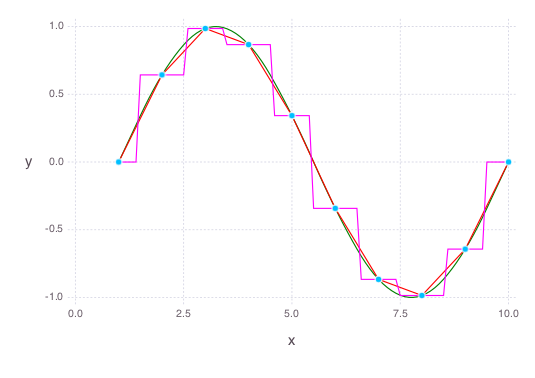

In [8]:
using Gadfly

plot(
    layer(x=xcoarse,y=ycoarse,Geom.point),
    layer(x=xfine,y=yconst,Geom.line,Theme(default_color=colorant"magenta")),
    layer(x=xfine,y=ylinear,Geom.line,Theme(default_color=colorant"red")),
    layer(x=xfine,y=yquadratic,Geom.line,Theme(default_color=colorant"green"))
)

### 2D interpolation

`Interpolations.jl` supports interpolation in arbitrary dimensions - just give it an `Array{T,N}` where elements `t::T` support operations like `a::Real * t + b::Real * t` and it will figure it out. However, since it starts getting difficult to visualize higher-dimensional functions, we'll stick with an example in 2D, namely the function $g(x,y) = x^2 \cdot \sin(y)$.

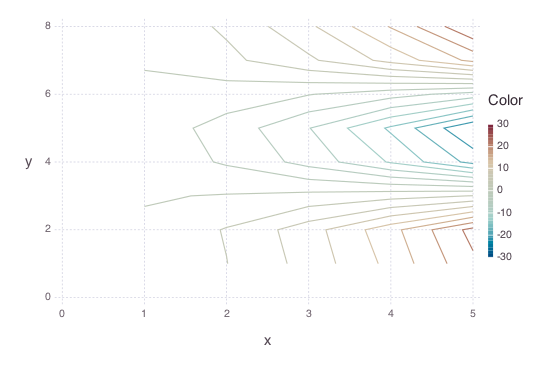

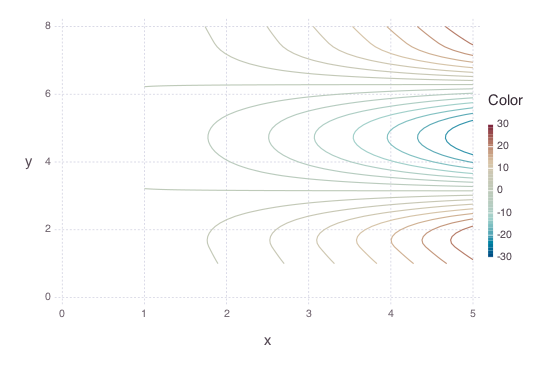

In [9]:
xs = 1:5
ys = 1:8
g = Float64[x^2 * sin(y) for x in xs, y in ys]

gitp_quad2d = interpolate(g, BSpline(Quadratic(Line())), OnCell())

display(plot(x=xs,y=ys,z=g,Geom.contour))
display(plot(x=1:.1:5, y=1:.1:8, z=[gitp_quad2d[x,y] for x in 1:.1:5, y in 1:.1:8], Geom.contour))

Simple, huh? =)

# Extrapolation

The behavior outside the domain is not carefully specified by `interpolate`, and most likely you should avoid using such objects outside the original domain. If you do want to control behavior outside the domain, you will likely be interested in `extrapolate`:

    yextr = extrapolate(yitp, Flat)

The `Flat` parameter to `extrapolate` signifies that we want the value to remain constant (flat) outside of the domain. Other options are...(how the interpolation object will behave when an index outside of the domain $[1, 10]$ is given; with `ExtrapError`, a `BoundsError` is thrown, while with `ExtrapNaN` (the only other implemented extrapolation behavior at the moment), `NaN` is returned.)

